In [ ]:
import kagglehub

# Download
path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")

print("Dataset baixado em:", path)

#https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/data

Using Colab cache for faster access to the 'cbis-ddsm-breast-cancer-image-dataset' dataset.
Dataset baixado em: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset


**Parte 1**

Verifica o caminho da pasta

In [10]:
from google.colab import drive
import os

# Monta o Google Drive na máquina virtual do Colab
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'

if os.path.exists(zip_path):
    print("Arquivo zip encontrado com sucesso!")
else:
    print(f"ERRO: Não encontrei o arquivo em {zip_path}. Verifique o nome da pasta/arquivo no Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arquivo zip encontrado com sucesso!


**Parte 1.1**

Encontra as imagens e combina com as informações (rótulos) do arquivo de metadados (CSV) para que o programa possa aprender com elas.


In [16]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- 1. CONFIGURAÇÃO E EXTRAÇÃO ---
# Caminho da imagem
ZIP_PATH = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'
EXTRACT_PATH = '/content/dados_extraidos'

if not os.path.exists(EXTRACT_PATH):
    print(f"Descompactando {ZIP_PATH}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Descompactação concluída.")
    except Exception as e:
        print(f"Erro ao descompactar: {e}")
        exit() # Para se der erro
else:
    print("Arquivos já descompactados anteriormente.")

# --- 2. MAPEAMENTO E PREPARAÇÃO DO DATASET (MODO POR PASTA/UID) ---
print("Localizando e processando metadados (CSVs)...")

csv_train = glob.glob(os.path.join(EXTRACT_PATH, "**", "mass_case_description_train_set.csv"), recursive=True)
csv_test = glob.glob(os.path.join(EXTRACT_PATH, "**", "mass_case_description_test_set.csv"), recursive=True)

if not csv_train:
    raise FileNotFoundError("CSV de treino não encontrado.")

df = pd.read_csv(csv_train[0])
if csv_test:
    df_test = pd.read_csv(csv_test[0])
    df = pd.concat([df, df_test], ignore_index=True)

# Mapeamento de Classes
def get_article_label(pathology):
    if 'MALIGNANT' in pathology: return 'Malignant'
    if 'BENIGN_WITHOUT_CALLBACK' in pathology: return 'Normal'
    if 'BENIGN' in pathology: return 'Benign'
    return None

df['label'] = df['pathology'].apply(get_article_label)
df = df.dropna(subset=['label'])

# --- INDEXA POR NOME DA PASTA (UID) ---
print("Indexando imagens pelo ID da pasta...")
folder_map = {}

# Varre todas as pastas e guarda onde estão as imagens JPG
for root, dirs, files in os.walk(EXTRACT_PATH):
    # Filtra apenas arquivos de imagem
    images_in_folder = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if images_in_folder:
        # O nome da pasta atual (aquele numero 1.3.6.1.4...) será a chave
        folder_name = os.path.basename(root)

        # Guarda o caminho completo das imagens dessa pasta
        full_paths = [os.path.join(root, img) for img in images_in_folder]
        folder_map[folder_name] = full_paths

print(f"Total de pastas com imagens encontradas: {len(folder_map)}")

# Cruzamento CSV <-> Imagem
valid_data = []
print("Cruzando dados (Buscando ID da pasta do CSV no disco)...")

for idx, row in df.iterrows():
    # Preferência: Imagem Recortada (ROI) > Imagem Completa
    # O CSV tem caminhos tipo: "Mass-Training_.../1.3.6.1.4.1...UID.../000000.dcm"
    paths_to_try = [row.get('cropped image file path'), row.get('image file path')]

    found_filepath = None

    for csv_path in paths_to_try:
        if pd.isna(csv_path): continue

        # Quebra o caminho do CSV em partes (separado por /)
        # Ex: ['Mass-Training...', '1.3.6.1.4.1.9590...', '1.3.6.1.4.1.9590...', '000000.dcm']
        path_parts = csv_path.split('/')

        # Verifica se alguma parte desse caminho corresponde a uma pasta que achamos no disco
        for part in path_parts:
            if part in folder_map:
                candidates = folder_map[part]

                # SE TIVER MAIS DE UMA IMAGEM NA PASTA (Caso da sua imagem 3: ROI + Máscara)
                # Pega a maior imagem (geralmente a textura do ROI é maior que a máscara binária)
                if len(candidates) > 1:
                    try:
                        # Pega o arquivo com maior tamanho em bytes (evita pegar a máscara preta)
                        found_filepath = max(candidates, key=os.path.getsize)
                    except:
                        found_filepath = candidates[0]
                else:
                    found_filepath = candidates[0]

                break

        if found_filepath: break

    if found_filepath:
        valid_data.append({'filepath': found_filepath, 'label': row['label']})

df_final = pd.DataFrame(valid_data)

# --- VERIFICAÇÃO FINAL ---
if len(df_final) == 0:
    print("\nERRO CRÍTICO PERSISTE.")
    print("Debug - Chaves encontradas no disco (exemplo):", list(folder_map.keys())[:3])
    print("Debug - Caminho no CSV (exemplo):", df.iloc[0]['image file path'])
    raise ValueError("Não foi possível casar as pastas do CSV com as pastas do disco.")

print(f"SUCESSO! Total de imagens vinculadas: {len(df_final)}")
print("Distribuição:\n", df_final['label'].value_counts())

Arquivos já descompactados anteriormente.
Localizando e processando metadados (CSVs)...
Indexando imagens pelo ID da pasta...
Total de pastas com imagens encontradas: 6774
Cruzando dados (Buscando ID da pasta do CSV no disco)...
SUCESSO! Total de imagens vinculadas: 1696
Distribuição:
 label
Malignant    784
Benign       771
Normal       141
Name: count, dtype: int64


In [12]:
df_final.head()

,filepath,label
0,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
1,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
2,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
3,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
4,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign


**Parte 2**

Filtro para termos apenas as bases quase balanceadas devida a mesma quantidade entre dados de maligno e benigno

In [20]:
df_final_binario = df_final[df_final['label'] != 'Normal']

# Reseta o índice
df_final_binario = df_final_binario.reset_index(drop=True)

print(f"Total de imagens restantes: {len(df_final_binario)}")
print("Nova distribuição:\n", df_final_binario['label'].value_counts())

Total de imagens restantes: 1555
Nova distribuição:
 label
Malignant    784
Benign       771
Name: count, dtype: int64


In [19]:
df_final_binario.head()

,filepath,label
0,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
1,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
2,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
3,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
4,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign


In [25]:
# Divisão Treino/Teste
train_df, val_df = train_test_split(df_final_binario, test_size=0.3, stratify=df_final_binario['label'], random_state=42)
print(f"Treino: {len(train_df)} | Teste/Validação: {len(val_df)}")

Treino: 1088 | Teste/Validação: 467


**Parte 3**

In [35]:
import cv2
import pywt
import numpy as np
from skimage.restoration import wiener
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence, to_categorical

# --- 3. PIPELINE DE PRÉ-PROCESSAMENTO E GERADORES ---

# Definição das funções de filtro
def process_pipeline(image_path):
    # Leitura
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return np.zeros((224,224,3))

    # Redimensiona
    img = cv2.resize(img, (224, 224))

    # A) Otsu Thresholding
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.bitwise_and(img, img, mask=mask)

    # B) Wiener Filter
    img = img.astype(np.float64) / 255.0
    psf = np.ones((5, 5)) / 25
    img = wiener(img, psf, balance=0.2)
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    # C) CLAHE Filter
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # D) Wavelet Packet Decomposition (db3, nível 2)
    coeffs = pywt.wavedec2(img, 'db3', level=2)
    coeffs[1] = tuple([np.zeros_like(v) for v in coeffs[1]]) # Suavização
    img = pywt.waverec2(coeffs, 'db3')
    img = np.clip(img, 0, 255).astype(np.uint8)

    # Converte para RGB
    img = cv2.resize(img, (224, 224))
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) / 255.0

# Classe do Gerador (2 CLASSES)
class DDSMGenerator(Sequence):
    def __init__(self, df, batch_size=10):
        self.df = df
        self.batch_size = batch_size
        self.le = LabelEncoder()

        # O LabelEncoder mapeia automaticamente: Benign -> 0, Malignant -> 1
        self.df['enc'] = self.le.fit_transform(self.df['label'])

        #  2 classes
        self.n_classes = 2
        self.indices = np.arange(len(self.df))

        # Guardar o mapeamento para conferência
        self.class_map = dict(zip(self.le.classes_, self.le.transform(self.le.classes_)))
        print(f"Mapeamento de Classes gerado: {self.class_map}")

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[indices]
        X, y = [], []
        for _, row in batch_data.iterrows():
            processed_img = process_pipeline(row['filepath'])
            X.append(processed_img)
            y.append(row['enc'])

        # um_classes=2 (pq não tem mais Classe Normal)
        return np.array(X), to_categorical(y, num_classes=2)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Instancia os geradores
print("Criando geradores de dados...")
# Adicionado a Divisão do que é Treino e Validação/Teste
print("Gerador de Treino -------")
train_gen = DDSMGenerator(train_df, batch_size=10)
print("Gerador de Validação/Teste -------")
val_gen = DDSMGenerator(val_df, batch_size=10)
print("Geradores prontos!")

Criando geradores de dados...
Gerador de Treino -------
Mapeamento de Classes gerado: {'Benign': np.int64(0), 'Malignant': np.int64(1)}
Gerador de Validação/Teste -------
Mapeamento de Classes gerado: {'Benign': np.int64(0), 'Malignant': np.int64(1)}
Geradores prontos!


In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.metrics import AUC

# --- 4. REDE NEURAL E TREINAMENTO (GOOGLE NET + ADAM) ---
print("\nInicializando GoogleNet (InceptionV3)...")

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)

# Dados binário, por isso 2
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação: Adicionado AUC na lista de metrics
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')]) # <--- AUC adicionada aqui

print("Iniciando treinamento...")

# Treinamento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    verbose=1
)

print("Treinamento concluído.")


Inicializando GoogleNet (InceptionV3)...
Iniciando treinamento...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 711s 6s/step - accuracy: 0.5211 - auc: 0.5301 - loss: 0.7963 - val_accuracy: 0.5435 - val_auc: 0.5630 - val_loss: 0.6946
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 693s 6s/step - accuracy: 0.5656 - auc: 0.5965 - loss: 0.6987 - val_accuracy: 0.5587 - val_auc: 0.6089 - val_loss: 0.6673
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 659s 6s/step - accuracy: 0.6062 - auc: 0.6350 - loss: 0.6675 - val_accuracy: 0.5304 - val_auc: 0.5559 - val_loss: 0.7006
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 663s 6s/step - accuracy: 0.5850 - auc: 0.6385 - loss: 0.6642 - val_accuracy: 0.5478 - val_auc: 0.5917 - val_loss: 0.7143
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 682s 6s/step - accuracy: 0.6353 - auc: 0.6927 - loss: 0.6333 - val_accuracy: 0.5565 - val_auc: 0.6066 - val_loss: 0.6732
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 651s 6s/step - accuracy: 0.6596 - auc: 0.7438 - loss: 0.5911 - val_accuracy: 0.5522 - val_auc: 0.6052 - val_loss: 0.7488
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━

**Parte Imagem**

Visualizando 5 imagens pré-processadas (Input da Rede):


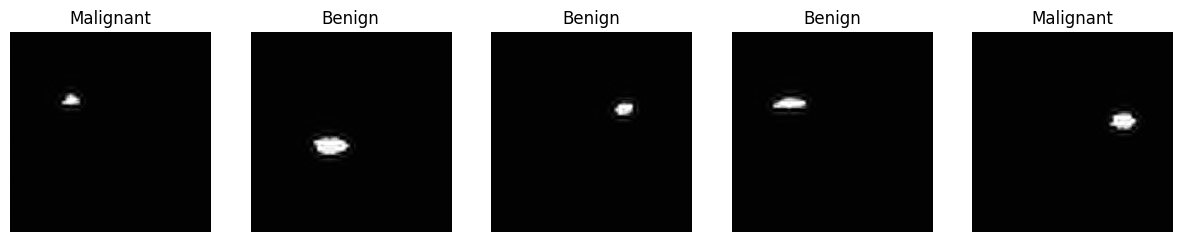

In [27]:
import matplotlib.pyplot as plt

# Pega um lote de teste
X_batch, y_batch = train_gen.__getitem__(0)

plt.figure(figsize=(15, 5))
print(f"Visualizando 5 imagens pré-processadas (Input da Rede):")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_batch[i])
    label_idx = np.argmax(y_batch[i])
    label_name = train_gen.le.inverse_transform([label_idx])[0]
    plt.title(label_name)
    plt.axis('off')
plt.show()

**Outro**

**Overfitting (Sobreajuste)**

A partir da época 12, a rede começou a "decorar" as imagens de treino (especialmente as repetidas da classe Normal) em vez de aprender os padrões gerais.

In [ ]:
# --- 4. REDE NEURAL E TREINAMENTO (GOOGLE NET + ADAM) ---
print("\nInicializando GoogleNet (InceptionV3)...")

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação: Adam com LR=0.0001
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Iniciando treinamento com dataset balanceado (1950 amostras)...")

# Treinamento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15, # Artigo usou até 100 iterações/épocas
    verbose=1
)

print("Treinamento concluído.")


Inicializando GoogleNet (InceptionV3)...
Iniciando treinamento com dataset balanceado (1950 amostras)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3897 - loss: 1.1359

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.3900 - loss: 1.1355 - val_accuracy: 0.4241 - val_loss: 1.1640
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 801s 6s/step - accuracy: 0.5174 - loss: 0.9867 - val_accuracy: 0.4983 - val_loss: 0.9821
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 786s 6s/step - accuracy: 0.6026 - loss: 0.8236 - val_accuracy: 0.5362 - val_loss: 0.8799
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 818s 6s/step - accuracy: 0.6039 - loss: 0.7907 - val_accuracy: 0.5310 - val_loss: 0.9732
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - accuracy: 0.6274 - loss: 0.7505 - val_accuracy: 0.5655 - val_loss: 0.8934
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 803s 6s/step - accuracy: 0.6833 - loss: 0.6681 - val_accuracy: 0.6172 - val_loss: 0.7900
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.6916 - loss: 0.6317 - val_accuracy: 0.5707 - val_loss: 1.0297
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 797s 6s/step - accuracy: 0.7516 - loss: 0.5610 - val_accuracy: 0.598

A rede aprendeu muito bem! Ela saiu de 36% para 95% no conjunto de treino. Isso prova que a arquitetura GoogleNet + Adam funciona e tem capacidade de aprender as características do câncer.

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

print("\nInicializando GoogleNet (InceptionV3) para Fine-Tuning...")

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 1. Descongelar as camadas do topo da GoogleNet
# As primeiras camadas congeladas (traços básicos) e treinar as últimas (formas complexas)
for layer in base_model.layers[:249]:
   layer.trainable = False
for layer in base_model.layers[249:]:
   layer.trainable = True

# 2. Recompilar com Learning Rate MUITO baixo
# Mantém Adam mas se reduz drasticamente o LR para não destruir o que já aprendeu.
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Iniciando Fine-Tuning (Descongelando camadas finais)...")

# 3. Continuar o treinamento
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    verbose=1
)


Inicializando GoogleNet (InceptionV3) para Fine-Tuning...
Iniciando Fine-Tuning (Descongelando camadas finais)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.3616 - loss: 1.1253 - val_accuracy: 0.4310 - val_loss: 1.0373
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.5159 - loss: 1.0012 - val_accuracy: 0.5672 - val_loss: 0.9228
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5833 - loss: 0.9005 - val_accuracy: 0.6310 - val_loss: 0.8410
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.6606 - loss: 0.7806 - val_accuracy: 0.6328 - val_loss: 0.7766
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.6870 - loss: 0.7193 - val_accuracy: 0.6397 - val_loss: 0.7163
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.7551 - loss: 0.5827 - val_accuracy: 0.6569 - val_loss: 0.6979
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.7938 - loss: 0.5146 - val_accuracy: 0.6655 - val_loss: 0.6683
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.8385 - loss: 0.4220 - val_accu

Data Augmentation

Pós Geradores Prontos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- NOVO GERADOR COM DATA AUGMENTATION ---
# Para combater o overfitting

class AugmentedDDSMGenerator(Sequence):
    def __init__(self, df, batch_size=10, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.augment = augment
        self.le = LabelEncoder()
        self.df['enc'] = self.le.fit_transform(self.df['label'])
        self.indices = np.arange(len(self.df))

        # Configuramos as distorções (rotação, zoom, flip)
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=20,      # Gira até 20 graus
                width_shift_range=0.1,  # Move horizontalmente
                height_shift_range=0.1, # Move verticalmente
                shear_range=0.1,        # Inclina
                zoom_range=0.1,         # Zoom leve
                horizontal_flip=True,   # Espelha
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[indices]

        X, y = [], []
        for _, row in batch_data.iterrows():
            # 1. Processa a imagem (Wiener, CLAHE, etc)
            img = process_pipeline(row['filepath'])
            X.append(img)
            y.append(row['enc'])

        X = np.array(X)
        y = to_categorical(y, num_classes=3)

        # 2. Se for treino, aplica a distorção aleatória na imagem processada
        if self.augment:
            # O flow do Keras espera 4D array, fazemos um truque para aplicar no batch
            iter_batch = self.datagen.flow(X, y, batch_size=self.batch_size, shuffle=False)
            return next(iter_batch)

        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Recriar os geradores
print("Recriando geradores com Data Augmentation...")
# Treino COM aumento de dados
train_gen_aug = AugmentedDDSMGenerator(train_df, batch_size=10, augment=True)
# Validação SEM aumento (queremos testar na imagem real)
val_gen_aug = AugmentedDDSMGenerator(val_df, batch_size=10, augment=False)
print("Pronto para re-treinar.")

Recriando geradores com Data Augmentation...
Pronto para re-treinar.


Pós geradores com Data Augmentation

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# --- 1. REINICIALIZAÇÃO DO MODELO (Para limpar o Overfitting anterior) ---
print("Reinicializando GoogleNet (InceptionV3) limpa...")

# Carrega a base com pesos da ImageNet (Transfer Learning)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Reconstrói as camadas finais conforme o artigo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Dropout de 50%
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação exata do artigo: Adam com LR 0.0001
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Modelo pronto para receber dados com Augmentation.")

Reinicializando GoogleNet (InceptionV3) limpa...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Modelo pronto para receber dados com Augmentation.


Treinamento Robusto (Com Data Augmentation)

Estagnação/Underfitting (Treino ~55%, Validação ~52%). A rede está tendo dificuldade para aprender os padrões reais diante das variações (rotações, zoom).

In [ ]:
# --- 2. TREINAMENTO COM DATA AUGMENTATION ---
print("Iniciando treinamento com Data Augmentation...")

history_aug = model.fit(
    train_gen_aug,
    validation_data=val_gen_aug, # Validação estática
    epochs=30,              # Aumentou-se as épocas
    verbose=1
)

print("Treinamento finalizado.")

Iniciando treinamento com Data Augmentation...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4750 - loss: 1.0239

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 719s 6s/step - accuracy: 0.4751 - loss: 1.0238 - val_accuracy: 0.5000 - val_loss: 0.9102
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 659s 5s/step - accuracy: 0.4852 - loss: 0.9515 - val_accuracy: 0.4920 - val_loss: 0.9621
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 656s 6s/step - accuracy: 0.5322 - loss: 0.8964 - val_accuracy: 0.4680 - val_loss: 0.9404
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 646s 5s/step - accuracy: 0.5295 - loss: 0.9098 - val_accuracy: 0.5120 - val_loss: 0.8843
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 648s 5s/step - accuracy: 0.5290 - loss: 0.9037 - val_accuracy: 0.5100 - val_loss: 0.8886
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 652s 6s/step - accuracy: 0.5167 - loss: 0.8909 - val_accuracy: 0.5020 - val_loss: 1.3118
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 653s 6s/step - accuracy: 0.5351 - loss: 0.8943 - val_accuracy: 0.4960 - val_loss: 0.9134
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 654s 6s/step - accuracy: 0.5196 - loss: 0.9243 - val_accuracy: 0.516